In [33]:
#Finding stay points from a user trajectory data.
#Stay points are goverened by two parameters, time threshold and distance threshold.
#If user has spend more than threshold time(10 mins) at the same geographical location(threshold distance 50m),
# then this location is users stay point.
#This can be users home, work, a bus station or a restaurant. 

#load all the files for a user
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 

pd.options.mode.chained_assignment = None

#----------------------------------------------------------------------------------------------------------------------
def load_user_file():
    global combined_df
    #Load file names for user. Change here for different user replace 000 or even path as required
    filenames = glob.glob(file_source_raw)

    #Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

    #put the data from list into one dataframe
    combined_df = pd.concat(list_of_dfs, ignore_index=True)

    #rename columns
    combined_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    combined_df['ClusterId'] = -1
    combined_df['ClusterMeanLat'] = -1
    combined_df['ClusterMeanLon'] = -1
    combined_df['StayPoint'] = -1
    combined_df['SignificantPlace'] = -1

    #add timestamp index
    combined_df["Timestamp"] = combined_df["Date"].map(str) + " " + combined_df["Time"]
    combined_df.Timestamp = pd.to_datetime(combined_df.Timestamp)
    combined_df.index = pd.to_datetime(combined_df.Timestamp)

    #combined_df.size
    #combined_df.head()

def resample_select_data():
    global combined_df
    global sampled_df
    #Resample the data with every one minutes. Remove this if you like to process the entire file.
    #Note, it could take some time to run the further sections of the file size is very large.
    sampled_df = combined_df.resample('1T').mean()
    sampled_df["Timestamp"] = sampled_df.index
    sampled_df = sampled_df.dropna()
    
    #Select the range of data you want to proceed with
    sampled_df = sampled_df[sampled_df["Timestamp"] <= fltr_till_date]

#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

#This function is to cluster the points together if thier distance is less than 50 meters.
#If the cluster has a total duration of 10 minutes or greater, then add it to a stay point

def cluster(newlat, newlon, row, count):
    
    currcluster = sampled_df['ClusterId'][row-1]
    sampled_df['ClusterId'][row] = -1
    sampled_df['ClusterMeanLat'][row] = -1
    sampled_df['ClusterMeanLon'][row] = -1
    sampled_df['StayPoint'][row] = -1
    sampled_df['SignificantPlace'][row] = -1
    clulat = sampled_df['ClusterMeanLat'][row-1]
    clulon = sampled_df['ClusterMeanLon'][row-1]
    
    #import pdb; pdb.set_trace()
    if meters(clulat, clulon, newlat, newlon)<= 50:
        sampled_df['ClusterId'][row] = currcluster
        sampled_df['ClusterMeanLat'] = sampled_df.groupby('ClusterId')['Latitude'].transform(np.mean)
        sampled_df['ClusterMeanLon'] = sampled_df.groupby('ClusterId')['Longitude'].transform(np.mean)
        count = count + 1
    else:
        
        if count >= 2:
            #import pdb; pdb.set_trace()
            MinClusTime = sampled_df['Timestamp'][row-count]
            MaxClusTime = sampled_df['Timestamp'][row-1]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            #import pdb; pdb.set_trace()
            if (l >= 10):
                sampled_df.loc[ (sampled_df['ClusterId']==currcluster), 'StayPoint'] = 1
        count = 1
        sampled_df['ClusterMeanLat'][row] = sampled_df['Latitude'][row]
        sampled_df['ClusterMeanLon'][row] = sampled_df['Longitude'][row]
        sampled_df['ClusterId'][row] = currcluster + 1
    return count

def find_stay_points():
    global sampled_df 
    global staypts_df
    
    #Read the file in an online manner as the points come and assign the points to clusters
    row =1
    count = 1
    sampled_df['ClusterId'][row-1] = 0
    sampled_df['ClusterMeanLat'][row-1] = sampled_df['Latitude'][0]
    sampled_df['ClusterMeanLon'][row-1] = sampled_df['Longitude'][0]
    sampled_df['StayPoint'][row-1] = -1
    sampled_df['SignificantPlace'][row-1] = -1
    while row < len(sampled_df):
        #import pdb; pdb.set_trace()
        count = cluster(sampled_df['Latitude'][row], sampled_df['Longitude'][row], row, count)
        row= row + 1

    #copy the stay points into another dataframe
    staypts_df = sampled_df.loc[sampled_df['StayPoint'] == 1]

def group_clusters():
    global staypts_df
    
    #this fucntion groups the clusters together from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    staypts_df1 = staypts_df[['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon']].copy()
    staypts_df1 = staypts_df1.drop_duplicates(subset=['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon'])

    staypts_df1 = staypts_df1.sort_values(['ClusterMeanLat', 'ClusterMeanLon'])

    row = 1
    for i in range(0, len(staypts_df1)):
        for j in range(i+1, len(staypts_df1)):
            #import pdb; pdb.set_trace()
        
            chk_cluster = staypts_df1['ClusterId'][i]
            chk_clulat = staypts_df1['ClusterMeanLat'][i]
            chk_clulon = staypts_df1['ClusterMeanLon'][i]
            curr_cluster = staypts_df1['ClusterId'][j]
            curr_clulat = staypts_df1['ClusterMeanLat'][j]
            curr_clulon = staypts_df1['ClusterMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= 50:
                staypts_df.loc[ (staypts_df['ClusterId']==curr_cluster), 'ClusterId'] = chk_cluster
                staypts_df['ClusterMeanLat'] = staypts_df.groupby('ClusterId')['ClusterMeanLat'].transform(np.mean)
                staypts_df['ClusterMeanLon'] = staypts_df.groupby('ClusterId')['ClusterMeanLon'].transform(np.mean)
            else:
                break
                
def save_file_stay_points():
    global staypts_df
    #Save the file to a location for further analysis
    staypts_df.to_csv(dest_file_staypoints, sep='\t', encoding='utf-8')

def cal_hourly_cluster_weight():
    global staypts_df
    global cluster_hourly_df

    #create two new dataframes with start and end of each hour for each cluster
    hourly_start_df = staypts_df.resample('H').first()
    hourly_end_df = staypts_df.resample('H').last()
    hourly_start_df = hourly_start_df.dropna()
    hourly_end_df = hourly_end_df.dropna()

    for i in range(0, 24):
        cluster_hourly_df['Date'] = 0
        cluster_hourly_df['ClusterId'] = 0
        cluster_hourly_df['AvgLat'] = 0
        cluster_hourly_df['AvgLon'] = 0
        cluster_hourly_df[i] = 0
    
    for i in range(0, staypts_df['ClusterId'].nunique()):
        if hourly_end_df['Timestamp'][i] == hourly_start_df['Timestamp'][i]:
            k = hourly_start_df.index[i+1] - hourly_start_df['Timestamp'][i]
        else:
            k = hourly_end_df['Timestamp'][i] - hourly_start_df['Timestamp'][i]
    
        l = (k / np.timedelta64(1, 'm')).astype(int)
        date_read = hourly_start_df.index[i].date()
        cluster_id = hourly_start_df['ClusterId'][i]
        ClusterMeanLat = hourly_start_df['ClusterMeanLat'][i]
        ClusterMeanLon = hourly_start_df['ClusterMeanLon'][i]
    
        col_name = hourly_start_df.index[i].hour 
        #import pdb; pdb.set_trace()
        cluster_hourly_df.loc[i, 'AvgLat'] = ClusterMeanLat
        cluster_hourly_df.loc[i, 'AvgLon'] = ClusterMeanLon
        cluster_hourly_df.loc[i, 'Date'] = date_read
        cluster_hourly_df.loc[i, 'ClusterId'] = cluster_id
        cluster_hourly_df.loc[i, col_name] = round((l)/60,4)
    
    cluster_hourly_df = cluster_hourly_df.fillna(0)
    cluster_hourly_df = cluster_hourly_df.groupby(['Date', 'ClusterId', 'AvgLat', 'AvgLon']).sum()
    cluster_hourly_df = cluster_hourly_df.replace(0, 0.0001)

def save_file_hourly_weights():
    global cluster_hourly_df
    
    #Save the file to a location for further analysis
    cluster_hourly_df.to_csv(dest_file_hourly_weights, sep='\t', encoding='utf-8')
#----------------------------------------------------------------------------------------------------------------------
#Start of the program
                                                                                                                                                                                                                                                                                                                                                                                                        
#global dataframes used
combined_df = pd.DataFrame()
sampled_df = pd.DataFrame()
staypts_df = pd.DataFrame()
cluster_hourly_df = pd.DataFrame()

#source, destination path and filter till date(till when the data needs to be considered). Change according to your needs
fltr_till_date = "2008-11-30 00:00:00"
file_source_raw = "/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/017/Trajectory/200*.plt" 
dest_file_staypoints = "/home/shashank/Documents/location/Data/User 17/staypoints/Till_" + fltr_till_date + ".csv"
dest_file_hourly_weights = "/home/shashank/Documents/location/Data/User 17/hourlyweights/Till_" + fltr_till_date + ".csv"


load_user_file()

resample_select_data()

find_stay_points()

group_clusters()

save_file_stay_points()

cal_hourly_cluster_weight()

save_file_hourly_weights()

In [46]:
#cluster_hourly_df.loc[cluster_hourly_df['Date' == "2008-10-30"]]
cluster_hourly_df

0       1       2       3   \
Date       ClusterId AvgLat    AvgLon                                       
2008-10-30 26.0      40.015260 116.338438  0.0001  0.0001  0.0001  0.0001   
           760.0     40.017587 116.345111  0.0001  0.0001  0.0001  0.0001   
2008-11-01 201.0     40.063329 116.403624  0.0001  0.0001  0.0001  0.0001   
2008-11-02 992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.0001   
           1626.0    40.029640 116.339447  0.0001  0.0001  0.0001  0.0001   
2008-11-04 992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.0001   
2008-11-05 992.0     40.017930 116.341351  0.0333  0.0001  0.0001  0.0001   
           1394.0    39.845488 116.373273  0.0001  0.0001  0.0001  0.0001   
2008-11-06 635.0     39.929227 116.347194  0.0001  0.0001  0.0001  0.0001   
           660.0     39.968439 116.411074  0.0001  0.0001  0.0001  0.0001   
           671.0     39.968336 116.409780  0.0001  0.0001  0.0001  0.0001   
           704.0     39.910734 116.357677  0.0001  0.0001  0.0001  0.0001   
           768.0     40.014163 116.346339  0.0001  0.0001  0.0001  0.0001   
           992.0     40.017930 116.341351  0.0001  0.0167  0.0001  0.0001   
           2073.0    39.967621 116.411552  0.0001  0.0001  0.0001  0.0001   
2008-11-07 992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.0001   
2008-11-08 911.0     39.867388 116.359954  0.0001  0.0001  0.0001  0.0001   
           944.0     39.923232 116.348817  0.0001  0.0001  0.0001  0.0001   
           992.0     40.017930 116.341351  6.8000  0.0001  0.0001  0.0001   

                                               4       5       6       7   \
Date       ClusterId AvgLat    AvgLon                                       
2008-10-30 26.0      40.015260 116.338438  0.0001  0.0001  0.0001  0.0001   
           760.0     40.017587 116.345111  0.0001  0.0001  0.0001  0.0001   
2008-11-01 201.0     40.063329 116.403624  0.0001  0.0001  0.0001  0.0001   
2008-11-02 992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.0001   
           1626.0    40.029640 116.339447  0.0001  0.0001  0.5333  0.9833   
2008-11-04 992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.0001   
2008-11-05 992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.0001   
           1394.0    39.845488 116.373273  0.4833  0.0333  0.0001  0.0001   
2008-11-06 635.0     39.929227 116.347194  0.4333  0.0001  0.0001  0.0001   
           660.0     39.968439 116.411074  0.0001  0.0001  0.9000  0.0001   
           671.0     39.968336 116.409780  0.0001  0.0001  0.0001  0.7333   
           704.0     39.910734 116.357677  0.0001  0.0001  0.0001  0.0001   
           768.0     40.014163 116.346339  0.0001  0.0001  0.0001  0.0001   
           992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.0001   
           2073.0    39.967621 116.411552  0.0001  0.3500  0.0001  0.0001   
2008-11-07 992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.0001   
2008-11-08 911.0     39.867388 116.359954  0.0001  0.0001  0.0001  0.0001   
           944.0     39.923232 116.348817  0.0001  0.0001  0.0001  0.0001   
           992.0     40.017930 116.341351  0.0001  0.0001  0.0001  0.6167   

                                               8       9    ...        14  \
Date       ClusterId AvgLat    AvgLon                       ...             
2008-10-30 26.0      40.015260 116.338438  0.0001  0.0667   ...    0.0001   
           760.0     40.017587 116.345111  0.0001  0.0001   ...    0.0001   
2008-11-01 201.0     40.063329 116.403624  0.2500  0.0001   ...    0.0001   
2008-11-02 992.0     40.017930 116.341351  0.0167  0.0001   ...    0.0001   
           1626.0    40.029640 116.339447  0.0001  0.0001   ...    0.0001   
2008-11-04 992.0     40.017930 116.341351  0.0001  0.0333   ...    0.0001   
2008-11-05 992.0     40.017930 116.341351  0.0167  0.0001   ...    0.0001   
           1394.0    39.845488 116.373273  0.0001  0.0001   ...    0.0001   
2008-11-06 635.0     39.929227 116.347194

In [31]:
staypts_df['ClusterId'].nunique()

106

In [122]:
#create two new dataframes with start and end of each hour for each cluster
hourly_start_df = staypts_df.resample('H').first()
hourly_end_df = staypts_df.resample('H').last()
hourly_start_df = hourly_start_df.dropna()
hourly_end_df = hourly_end_df.dropna()
#hourly_start_df['Timestamp'] = pd.to_datetime(staypts_df.Timestamp)
hourly_start_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2008-10-30 09:00:00 to 2008-11-14 07:00:00
Data columns (total 11 columns):
Latitude            70 non-null float64
Longitude           70 non-null float64
0                   70 non-null float64
Altitude            70 non-null float64
NumDays             70 non-null float64
ClusterId           70 non-null float64
ClusterMeanLat      70 non-null float64
ClusterMeanLon      70 non-null float64
StayPoint           70 non-null float64
SignificantPlace    70 non-null float64
Timestamp           70 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 6.6 KB


In [117]:
staypts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2008-10-30 09:54:00 to 2008-11-14 07:28:00
Data columns (total 11 columns):
Latitude            321 non-null float64
Longitude           321 non-null float64
0                   321 non-null float64
Altitude            321 non-null float64
NumDays             321 non-null float64
ClusterId           321 non-null float64
ClusterMeanLat      321 non-null float64
ClusterMeanLon      321 non-null float64
StayPoint           321 non-null float64
SignificantPlace    321 non-null float64
Timestamp           321 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 30.1 KB


In [123]:
#create a new dataframe which will hold the hourly distribustion of the staypoints
cluster_hourly_df = pd.DataFrame()

for i in range(0, 24):
    cluster_hourly_df['Date'] = 0
    cluster_hourly_df['ClusterId'] = 0
    cluster_hourly_df[i] = 0
cluster_hourly_df.head()

,Date,ClusterId,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23


In [124]:
for i in range(0, staypts_df['ClusterId'].nunique()):
    k =  hourly_end_df['Timestamp'][i] -hourly_start_df['Timestamp'][i]
    l = (k / np.timedelta64(1, 'm')).astype(int)
    date_read = hourly_start_df.index[i].date()
    cluster_id = hourly_start_df['ClusterId'][i]
    
    col_name = hourly_start_df.index[i].hour 
    #import pdb; pdb.set_trace()
    cluster_hourly_df.loc[i, 'Date'] = date_read
    cluster_hourly_df.loc[i, 'ClusterId'] = cluster_id
    cluster_hourly_df.loc[i, col_name] = (l+1)/60
    
#cluster_hourly_df = cluster_hourly_df.fillna(0.01)
cluster_hourly_df

,Date,ClusterId,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,2008-10-30,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-10-30,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-10-30,760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-11-01,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-11-02,231.0,NaN,NaN,NaN,NaN,NaN,NaN,0.016667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2008-11-02,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2008-11-02,992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2008-11-02,992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033333
8,2008-11-04,992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2008-11-05,992.0,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
for i in range(0, staypts_df['ClusterId'].nunique()):
    if hourly_end_df['Timestamp'][i] == hourly_start_df['Timestamp'][i]:
        k = hourly_start_df.index[i+1] - hourly_start_df['Timestamp'][i]
    else:
        #k = hourly_end_df['Timestamp'][i] - hourly_start_df['Timestamp'][i]
        k =  hourly_end_df['Timestamp'][i] -hourly_start_df['Timestamp'][i]

    l = (k / np.timedelta64(1, 'm')).astype(int)
    date_read = hourly_start_df.index[i].date()
    cluster_id = hourly_start_df['ClusterId'][i]

    col_name = hourly_start_df.index[i].hour 
    #import pdb; pdb.set_trace()
    cluster_hourly_df.loc[i, 'Date'] = date_read
    cluster_hourly_df.loc[i, 'ClusterId'] = cluster_id
    cluster_hourly_df.loc[i, col_name] = round((l)/60,4)

cluster_hourly_df = cluster_hourly_df.fillna(0.0001)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [61]:
hourly_start_df.head()

,Latitude,Longitude,0,Altitude,NumDays,ClusterId,ClusterMeanLat,ClusterMeanLon,StayPoint,SignificantPlace,Timestamp
Timestamp,,,,,,,,,,,
2008-10-30 09:00:00,40.015234,116.338775,0.0,118.10,39751.412773,26.0,40.015260,116.338438,1.0,-1.0,2008-10-30 09:54:00
2008-10-30 10:00:00,40.015323,116.338242,0.0,114.80,39751.418015,26.0,40.015260,116.338438,1.0,-1.0,2008-10-30 10:01:00
2008-10-30 12:00:00,40.017840,116.345113,0.0,163.36,39751.510722,760.0,40.017587,116.345111,1.0,-1.0,2008-10-30 12:15:00
2008-11-01 08:00:00,40.063372,116.403605,0.0,177.20,39753.353692,201.0,40.063329,116.403624,1.0,-1.0,2008-11-01 08:29:00
2008-11-02 06:00:00,40.029733,116.339315,0.0,91.90,39754.269537,231.0,40.029738,116.339309,1.0,-1.0,2008-11-02 06:28:00


In [62]:
hourly_end_df.head()

,Latitude,Longitude,0,Altitude,NumDays,ClusterId,ClusterMeanLat,ClusterMeanLon,StayPoint,SignificantPlace,Timestamp
Timestamp,,,,,,,,,,,
2008-10-30 09:00:00,40.015582,116.338158,0.0,114.800,39751.415926,26.0,40.015260,116.338438,1.0,-1.0,2008-10-30 09:58:00
2008-10-30 10:00:00,40.015206,116.338924,0.0,103.350,39751.420600,26.0,40.015260,116.338438,1.0,-1.0,2008-10-30 10:05:00
2008-10-30 12:00:00,40.017314,116.345025,0.0,191.125,39751.521780,760.0,40.017587,116.345111,1.0,-1.0,2008-10-30 12:31:00
2008-11-01 08:00:00,40.063325,116.403652,0.0,177.200,39753.364005,201.0,40.063329,116.403624,1.0,-1.0,2008-11-01 08:44:00
2008-11-02 06:00:00,40.029733,116.339315,0.0,91.900,39754.269537,231.0,40.029738,116.339309,1.0,-1.0,2008-11-02 06:28:00


In [63]:
k =  hourly_end_df['Timestamp'][3] -hourly_start_df['Timestamp'][3]
l = (k / np.timedelta64(1, 'm')).astype(int)
l

15

In [64]:
list_clusterids = staypts_df['ClusterId'].unique()
hourly_start_df.index[1].hour

10

,Date,ClusterId,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23


In [80]:
hourly_start_df.index[1].time()

datetime.time(10, 0)

In [88]:

cluster_hourly_df

,Date,ClusterId,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,2008-10-30,26.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
1,2008-10-30,26.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
2,2008-10-30,760.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
3,2008-11-01,201.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
4,2008-11-02,231.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.5333,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
5,2008-11-02,231.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.9833,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
6,2008-11-02,992.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
7,2008-11-02,992.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0167
8,2008-11-04,992.0,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001
9,2008-11-05,992.0,0.0333,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001


In [68]:
#load the staypoints file
staypts_df = pd.read_csv(dest_file_staypoints, sep='\t')

#make index as datetime
staypts_df.index = pd.to_datetime(staypts_df.Timestamp)

#add a column hour for pivot table
staypts_df['Hour'] = staypts_df.index.hour

#sort based on hours
staypts_df = staypts_df.sort_values(['Hour'])

#count a cluster existence in each hour of te day
pivot_df_hour_count = staypts_df.pivot_table(values='Latitude', index='ClusterId',columns='Hour',aggfunc=len,  fill_value=0)

#copy hour count pivot to a new pivot where percentage weight of each staypount in the hour is calculated
pivot_df_hour_count.columns.name = None
pivot_df_per_weight = pivot_df_hour_count.copy()

for column in pivot_df_per_weight:
    pivot_df_per_weight[column] = round(pivot_df_per_weight[column] / pivot_df_per_weight[column].sum() * 100, 2)
    
pivot_df_per_weight

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,19,23
ClusterId,,,,,,,,,,,,,,,,,,
26.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.0,11.76,0.00,0.0,0.00,0.0,0.0,0.0,0.0
201.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,38.89,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
231.0,0.0,0.00,0.00,0.00,0.00,0.00,3.12,8.33,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
635.0,0.0,0.00,0.00,0.00,27.27,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
659.0,0.0,0.00,0.00,0.00,0.00,19.05,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
660.0,0.0,0.00,0.00,0.00,0.00,9.52,18.75,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
671.0,0.0,0.00,0.00,0.00,0.00,0.00,28.12,16.67,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
704.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,16.67,5.56,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
760.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,60.0,0.00,0.0,0.0,0.0,0.0


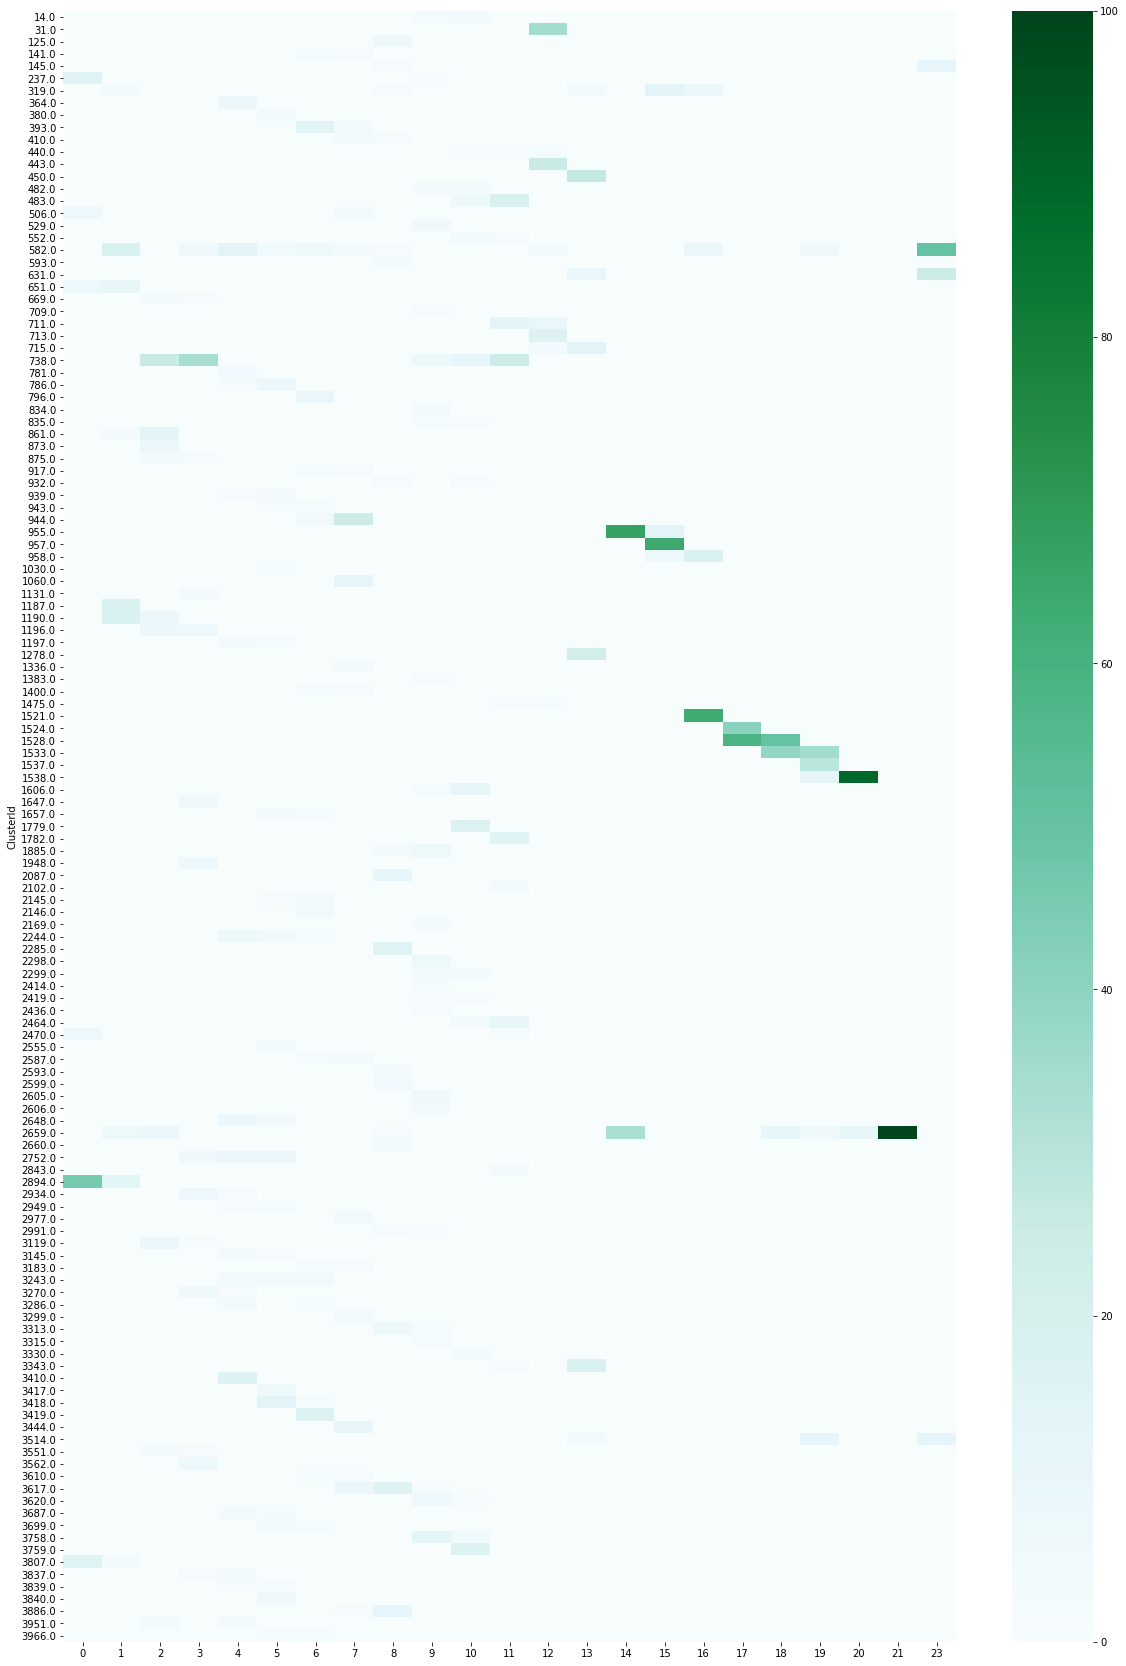

In [11]:
#visualize the staypoint percentage weight per hour
fig, ax = plt.subplots(figsize=(20,30)) 
sns.heatmap(pivot_df_per_weight, cmap='BuGn', ax=ax)

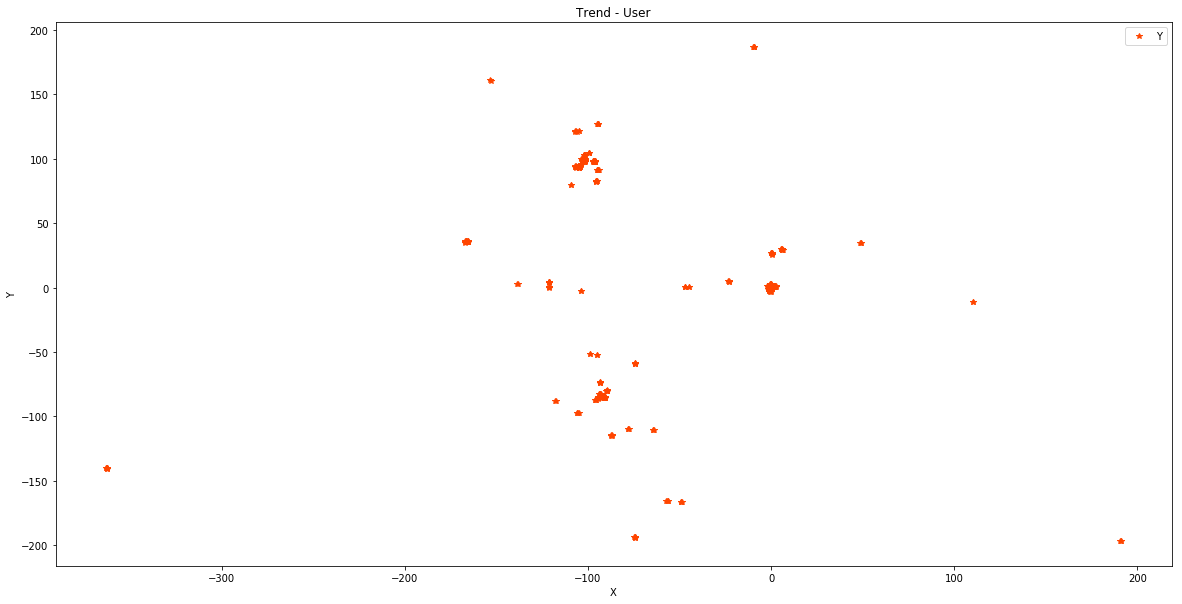

In [11]:
#Plot the significant places
#assign the first lat and log as the base for the plot i.e. origin
origin_lat = math.radians(combined_df["Latitude"][0])
origin_lon = math.radians(combined_df["Longitude"][0])
staypts_df = staypts_df.reset_index(drop=True)

#assign the first lat and log as the base for the plot i.e. origin
origin_lat = math.radians(staypts_df["Latitude"][0])
origin_lon = math.radians(staypts_df["Longitude"][0])

#convert each lat and lon into x and y for the plot w.r.t origin
EARTH_RAD = 6378100
staypts_df['X'] = 0.0
staypts_df['Y'] = 0.0
for i in range(0, len(staypts_df)):
    x = 0
    y = 0
    current_lat = math.radians(staypts_df["Latitude"][i])
    current_lon = math.radians(staypts_df["Longitude"][i])
    x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
    y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
    staypts_df.at[i, 'X'] = x
    staypts_df.at[i, 'Y'] = y

#plot the x and y's
staypts_df.plot(x='X', y= 'Y' , style='*', figsize=(20,10), color='orangered')
plt.title('Trend - User')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()